## Feature Extraction using Convolutional Autoencoder

In this notebook, We aim to use convolutional autoencoder replace Gabor filters to extract features from patches. Convolutional filters reduce the number of parameters to be learned and imporve the performance while the autoencoder can help us learn a model without labels.

The architecture of the autoencoder is displayed below. we pick output of the narrowest layer as extracted features.
<img src="../images/autoencoder.png">

## 1.initialization

In [80]:
#initialization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import caffe
import cv2
caffe.set_mode_gpu()

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
#load the trained model
net = caffe.Net('../models/autoencoder/md593_autoencoder_test.prototxt','../models/autoencoder/md593_autoencoder_iter_6000.caffemodel', caffe.TEST)

## 2. Reconstruction
### Example patch

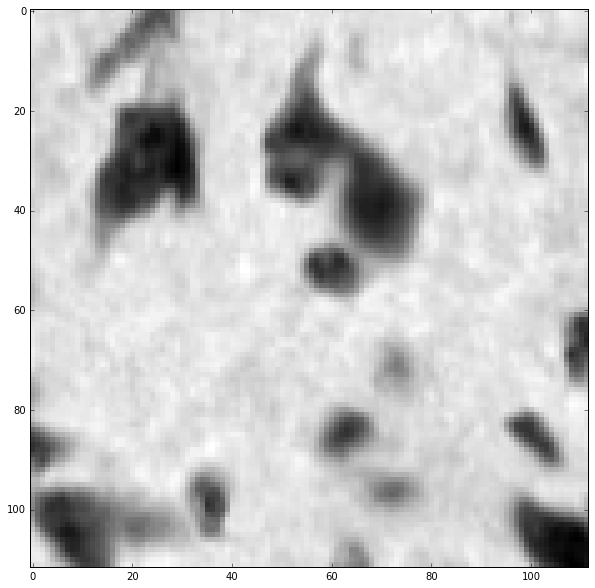

In [81]:
img = cv2.imread('../images/md593_test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

### The reconstructed result
We can see that the reconstructed result preserves most features of the example patch.

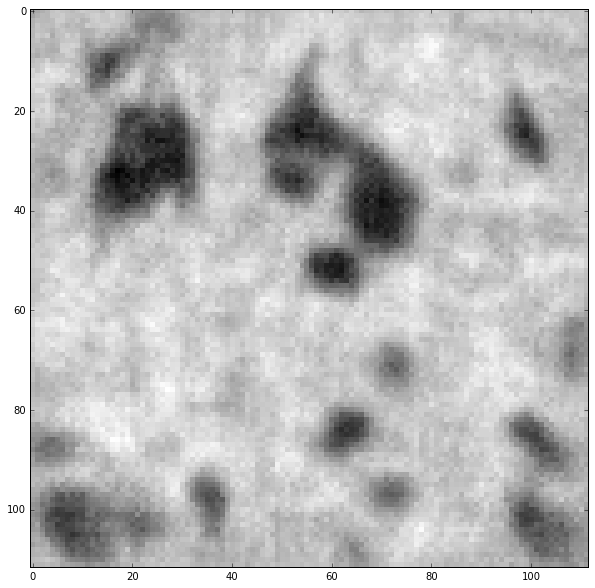

In [82]:
#plot test reconstructed patch
net.blobs['data'].data[...] = img * 0.00392156862
out = net.forward()
tmp = out['deconv1'].reshape(112,112)
plt.imshow(tmp)

In [83]:
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data.transpose(2,0,1).reshape(48, 48))

## 3. Filter Visulization
Below is the visualization of the first convolutional layer. It's kind of strange that the visualization doesn't explictly show the features of filters since the reconstruction goes well.

(16, 1, 11, 11)


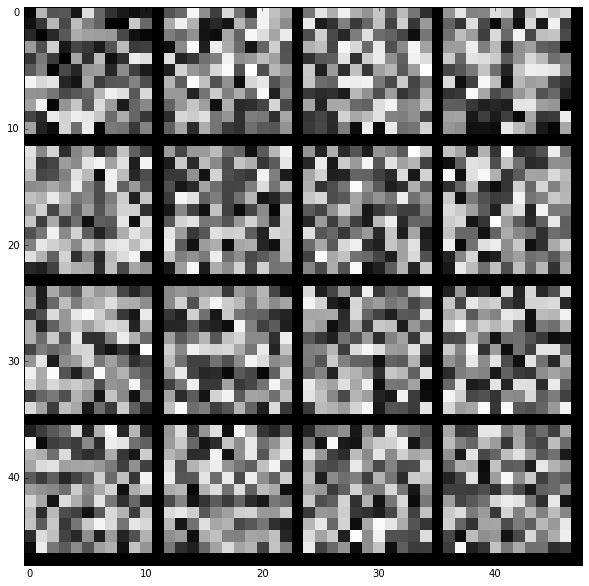

In [84]:
#visualized filters of conv1
filters = net.params['conv1'][0].data
print filters.shape
vis_square(filters.transpose(0, 2, 3, 1))
#filters = net.params['conv1'][0].data.reshape(4, 4, 11, 11).transpose(0, 2, 1, 3).reshape(4*11, 4*11)
#plt.imshow(filters)

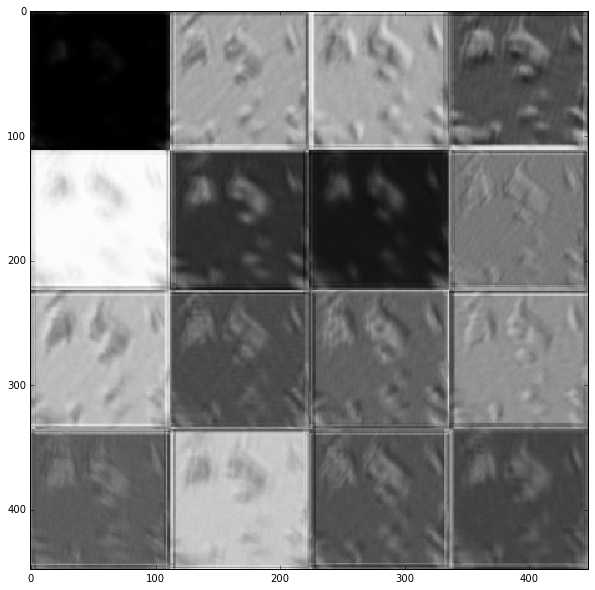

In [85]:
#show feature maps of layer conv1
fMap = net.blobs['conv1'].data[0].reshape(4, 4, 112, 112).transpose(0, 2, 1, 3).reshape(4*112, 4*112)
plt.imshow(fMap)

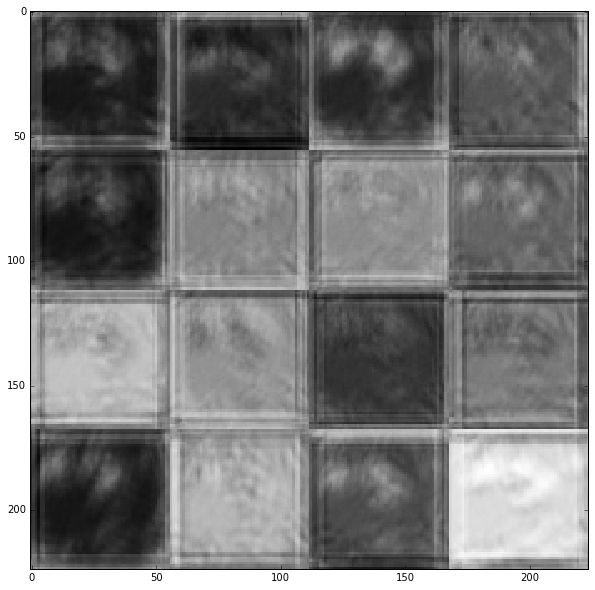

In [86]:
#show feature maps of layer conv2
fMap = net.blobs['conv2'].data.reshape(4,4,56,56).transpose(0, 2, 1, 3).reshape(4*56, 4*56)
plt.imshow(fMap)

## 4. More details
1. We use **tanh()** instead of **ReLU()**
2. We use Euclid distance as reconstruction error.
3. We use a modified caffe version [csd395 caffe](https://github.com/LiamZhuuu/caffe)

## 5. Reference
1. [Unsupervised Learning of Invariant Feature Hierarchies with Applications to Object Recognition](http://yann.lecun.com/exdb/publis/pdf/ranzato-cvpr-07.pdf)
2. [Learning Deconvolution Network for Semantic Segmentation](http://cvlab.postech.ac.kr/research/deconvnet/)
3. [Stacked Convolutional Auto-Encoders for Hierarchical Feature Extraction](http://people.idsia.ch/~ciresan/data/icann2011.pdf)